In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [2]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

qiskit_runtime_service.__init__:INFO:2024-03-22 13:43:21,106: Default instance: ibm-q/open/main


'ibm_kyoto'

In [3]:
def grover_oracle(marked_states):

     # this function builds an oracle we use in our algorithm
        
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

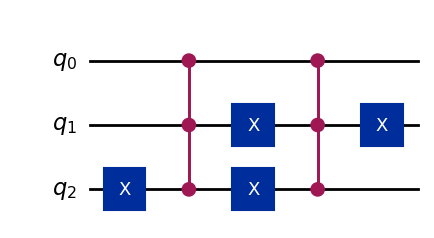

In [4]:
marked_states = ["011", "101"]     # testing
oracle = grover_oracle(marked_states)
oracle.draw()

In [5]:
import math
# finding optimum number of amplification steps
grover_op = GroverOperator(oracle)
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits))))

In [6]:
# the full grover circuit
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()


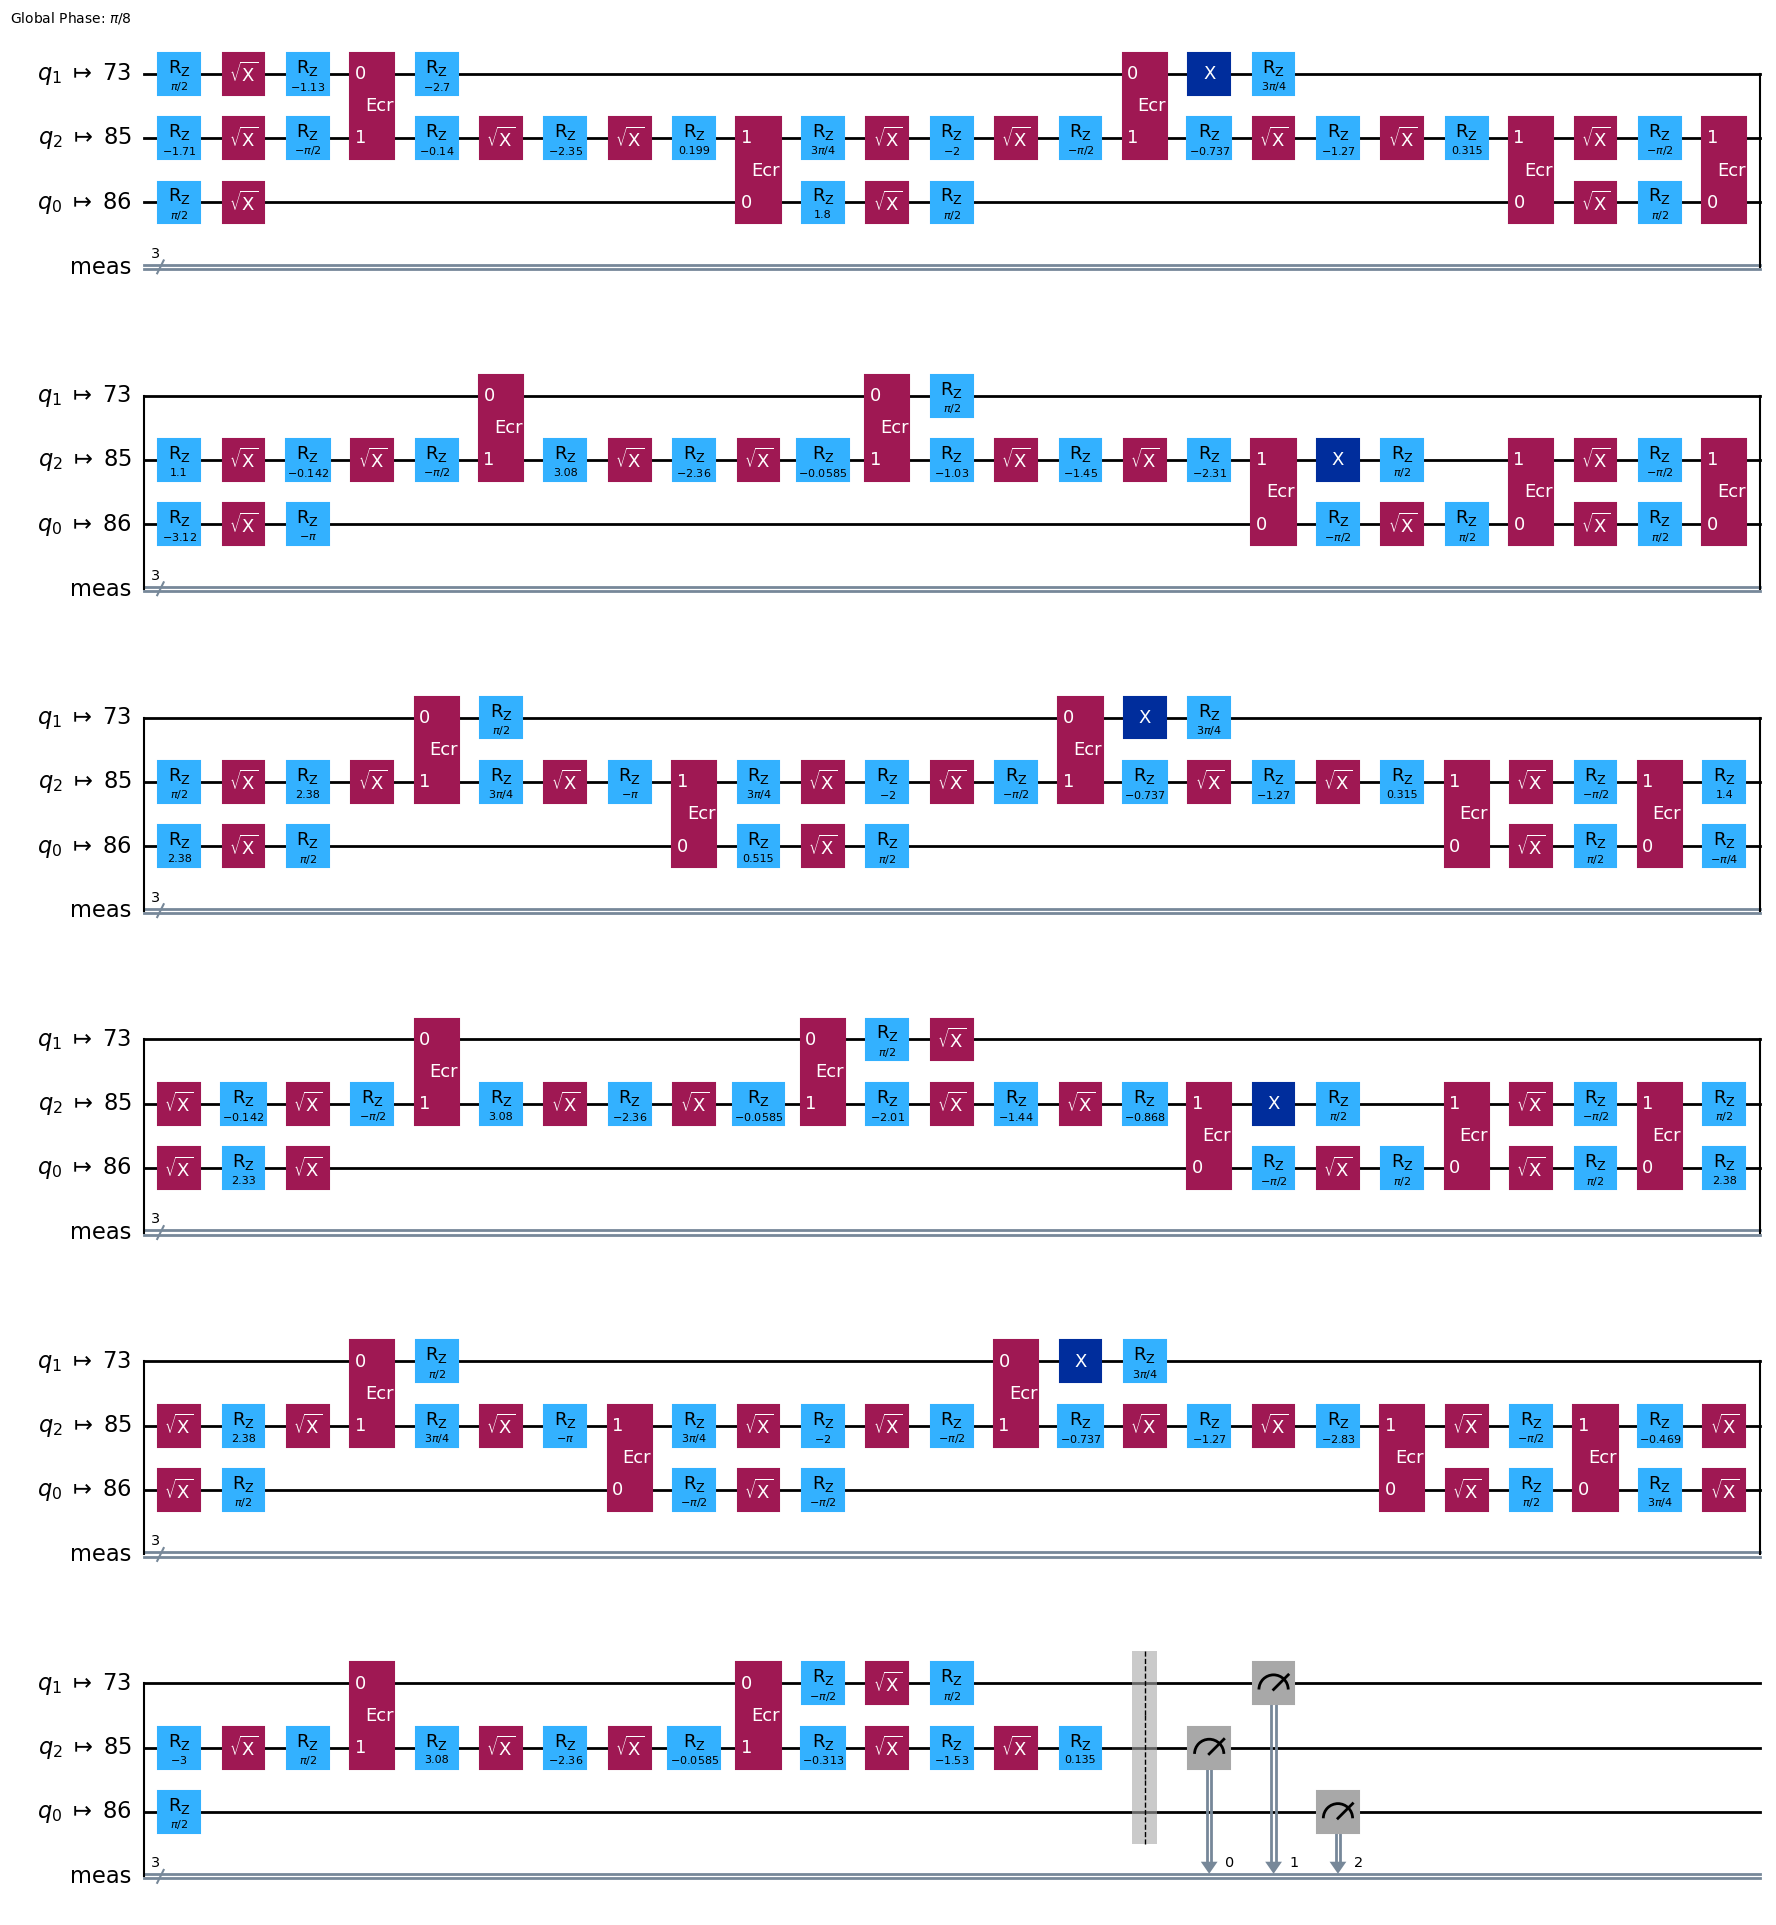

In [7]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [ ]:
sampler = Sampler(backend=backend)
sampler.options.default_shots = 5
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

base_primitive._run:INFO:2024-03-22 13:44:14,233: Submitting job using options {'options': {'default_shots': 5}, 'version': 2, 'support_qiskit': True}


In [ ]:
plot_distribution(dist)